<h1 STYLE="padding-left:1em;text-align: center;">Projet 07 : Développez une preuve de concept </h1>

#  Introduction  
<p STYLE="padding-left:1em;text-align:justify;">Ce projet porte sur la recherche d’un nouveau concept et son prototypage, à partir de l’état de l’art du domaine, permettant d’améliorer les performances obtenues sur la méthode utilisée mise en production chez un client.

# Sommaire
<a href="#1" STYLE="padding-left:1em;color:black"><b>Etape 1 : Importation des librairies </b></a><br>
<a href="#2" STYLE="padding-left:1em;color:black"><b>Etape 2 : Baseline : CNN+Transfert learning</b></a><br>
<a href="#2.1" STYLE="padding-left:2em;color:black">2.1 Modèle InceptionResNetV2 : Dataset : 'dogs'</a><br>
<a href="#2.2" STYLE="padding-left:2em;color:black">2.2 Modèle InceptionResNetV2 : Dataset : 'birds'</a><br>
<a href="#3" STYLE="padding-left:1em;color:black"><b>Etape 3 : Vision Transformers</b></a><br>

# <a STYLE="color:black" id="1">Etape 1 : Importation des librairies et oréparation des répertoires

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from pathlib import Path

from joblib import parallel_backend, Parallel, delayed , dump , load

import functools

from numba import cuda 

import tensorflow as tf
from tensorflow import keras
from keras import layers , Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, save_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report,confusion_matrix

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth', 200)

In [3]:
repertory = os.path.abspath('')+'/drive/MyDrive/Colab Notebooks/P07/'
repertory = repertory if os.path.isdir(repertory) else os.path.abspath('')
path_dir_dogs = repertory+'/Dataset/Dataset_dogs/'
path_dir_birds = repertory+'/Dataset/Dataset_birds/'

In [4]:
def choice_path(data = 'dogs', aug_data = True):

    path_dir = repertory+'/Dataset/Dataset_'+data+'/'

    train_path = path_dir+'train'
    test_path = path_dir+'test'

    val_path = path_dir+'val_set'
    pred_path = path_dir+'pred_set'
    
    augment_data = '_aug_data' if aug_data == True else ''

    models_path = repertory+'/Models/Models_'+data + augment_data+'/'
    results_path = repertory+'/Results/Results_'+data + augment_data+'/'
    
    return path_dir, train_path, test_path , val_path, pred_path , models_path , results_path 

path_dir, train_path, test_path , val_path, pred_path , models_path , results_path  = choice_path('dogs', aug_data = False)

# <a STYLE="color:black" id="2">Etape 2 : Baseline : CNN+Transfert learning</a> 
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Dans cette partie, nous allons re-utiliser le modèle "InceptionResNetV2" qui est celui où nous avons obtenu les meilleurs résultats en termes de score de prédiction pour la classification d'image lors du projet précédent.<br>Contrairement au projet précédent, je n’ai pas appliqué la méthode de « Data Augmentation » afin d’augmenter artificiellement le nombre d’image par classes en les multipliant et en appliquant diverses transformations (rotation, flip, zoom, …), car je n’ai pas pu l’implémenter dans le modèle de Vision Transformers</b></p> 

## <a STYLE="padding-left:1em ; color:blue;text-align: justify;" id="2.1">2.1 Modèle InceptionResNetV2 : Dataset : 'dogs'</a> 



In [5]:
def plot_metrics(model):

    losses = model if isinstance(model, pd.DataFrame) else pd.DataFrame(model.history.history) 
    acc = losses['accuracy']
    val_acc = losses['val_accuracy']

    loss = losses['loss']
    val_loss = losses['val_loss']

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc.index, acc, label='Training Accuracy')
    plt.plot(val_acc.index, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss.index, loss, label='Training Loss')
    plt.plot(val_loss.index, val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')
    plt.show()

In [6]:
def process_files(train_path, test_path , img_shape):

    train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,label_mode='categorical',shuffle=True,batch_size=batch_size,image_size=img_shape[:2])
    validation_dataset = tf.keras.utils.image_dataset_from_directory(test_path,label_mode='categorical',shuffle= False , batch_size=batch_size,image_size=img_shape[:2])

    class_names = train_dataset.class_names

    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

    name = 'dogs' if 'dogs' in path_dir else 'birds'

    dump(class_names , models_path+'classes_'+name+'.joblib',compress = True) 

    total_img_train = 0
    total_img_test = 0

    for root, dirs, files in os.walk(train_path):
        total_img_train += len(files)

    for root, dirs, files in os.walk(test_path):
        total_img_test += len(files)

    steps_per_epoch_train = round(total_img_train/batch_size+0.5)
    steps_per_epoch_test = round(total_img_test /batch_size+0.5)
    print(steps_per_epoch_train,steps_per_epoch_test)

    return train_dataset , validation_dataset, steps_per_epoch_train, steps_per_epoch_test , class_names

In [7]:
def model_build(base_model, seq_model, class_names, img_shape , preprocess_input = None , aug_data = True  ) : 
    
    data_augmentation = tf.keras.Sequential([layers.Resizing(img_shape[0], img_shape[1]),
                                          layers.RandomFlip("horizontal"),
                                          layers.RandomWidth(0.2),
                                          layers.RandomHeight(0.2),
                                          layers.RandomRotation(0.2),
                                          layers.RandomZoom(0.2),
                                          layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
                                          layers.RandomContrast(factor=0.2) ] )
    normalization_layer = layers.Rescaling(1./255)

    input = tf.keras.Input(shape=img_shape)
    x = data_augmentation(input) if aug_data == True else input
    x = preprocess_input(x) if preprocess_input is not None else normalization_layer(x) 
    x = base_model(x, training=False)
    x = seq_model(x)
    
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    
    model = keras.Model(input, outputs)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [8]:
def fit_model(model ,  model_name , train_dataset , validation_dataset ):
    if os.path.isfile(models_path+str(model_name)+'.h5'): 
        model = load_model(models_path+str(model_name)+'.h5')
        results = load(results_path+'score_'+str(model_name)+'.joblib')
        model.summary()
        plot_metrics(results)

    else :
        model.summary()
        early_stop = EarlyStopping(monitor='val_loss', patience=5)
        model.fit(train_dataset, steps_per_epoch=steps_per_epoch_train, epochs=100, validation_data=validation_dataset,
                 validation_steps=steps_per_epoch_test, callbacks=[early_stop])
                 
        results = pd.DataFrame(model.history.history)
        plot_metrics(model)
        
        dump(results,results_path+'score_'+str(model_name)+'.joblib',compress = True)
        model.save(models_path+str(model_name)+'.h5') 
    
    return model , results

In [9]:
batch_size = 64
img_shape = (299,299,3)
new_imput = keras.Input(shape=(299,299,3))

path_dir, train_path, test_path , val_path, pred_path , models_path , results_path = choice_path('dogs',  aug_data = False)
train_dataset, validation_dataset, steps_per_epoch_train, steps_per_epoch_test,class_names = process_files(train_path, test_path , img_shape)

Found 16376 files belonging to 120 classes.
Found 4085 files belonging to 120 classes.
256 64


In [10]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2 , preprocess_input,  decode_predictions

preprocess_input_InceptionResNetV2 = preprocess_input

model_base_InceptionResNetV2 = InceptionResNetV2(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_InceptionResNetV2.trainable = False
# model_base_InceptionResNetV2.summary()

seq_InceptionResNetV2 = tf.keras.Sequential([GlobalAveragePooling2D()])

model_InceptionResNetV2 = model_build(model_base_InceptionResNetV2 ,seq_InceptionResNetV2,class_names, img_shape , preprocess_input_InceptionResNetV2 , aug_data = False )

219070464/219055592 [==============================] - 6s 0us/step


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 sequential_2 (Sequential)   (None, 1536)              0         
                                                           

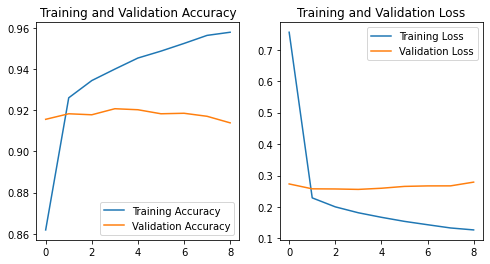

CPU times: user 6.84 s, sys: 439 ms, total: 7.28 s
Wall time: 13.6 s


In [11]:
%%time
transfert_InceptionResNetV2, score_transfert_InceptionResNetV2 = fit_model(model_InceptionResNetV2, 'transfert_InceptionResNetV2',train_dataset , validation_dataset)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Réglage fin

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 sequential_2 (Sequential)   (None, 1536)              0         
                                                           

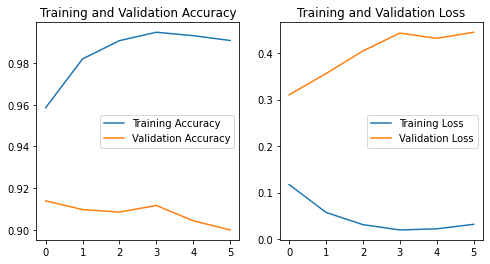

CPU times: user 8.99 s, sys: 1.21 s, total: 10.2 s
Wall time: 22.8 s


In [12]:
%%time
model_base_InceptionResNetV2.trainable = True
transfert_InceptionResNetV2.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                                    loss='categorical_crossentropy',metrics=['accuracy'])

transfert_InceptionResNetV2_ajust, score_transfert_InceptionResNetV2_ajust = fit_model(transfert_InceptionResNetV2,'transfert_InceptionResNetV2_ajust',train_dataset , validation_dataset)                                                                                     

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons un léger sur-apprentissage du modèle, dû probablement à l'absence de la méthode de "Data Augmentation" qui permet d'augmenter artificiellement le nombre d'images par classes. Pour limiter cela, nous allons ajouter une couche de <span STYLE="color:gray;"><i> Dropout</i></span> avant la couche de neurones de sorties.

In [13]:
score_transfert_InceptionResNetV2.iloc[-1] , score_transfert_InceptionResNetV2_ajust.iloc[-1]

(loss            0.126918
 accuracy        0.957804
 val_loss        0.278945
 val_accuracy    0.913831
 Name: 8, dtype: float64, loss            0.031929
 accuracy        0.990962
 val_loss        0.444682
 val_accuracy    0.899878
 Name: 5, dtype: float64)

In [14]:
model_base_InceptionResNetV2_02 = InceptionResNetV2(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_InceptionResNetV2_02.trainable = False
# model_base_InceptionResNetV2_02.summary()

seq_InceptionResNetV2_02 = tf.keras.Sequential([GlobalAveragePooling2D(),
                                                layers.Dropout(0.3),
                                                ])

model_InceptionResNetV2_02 = model_build(model_base_InceptionResNetV2_02 ,seq_InceptionResNetV2_02,class_names, img_shape, preprocess_input_InceptionResNetV2 , aug_data = False    )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 sequential_4 (Sequential)   (None, 1536)              0         
                                                           

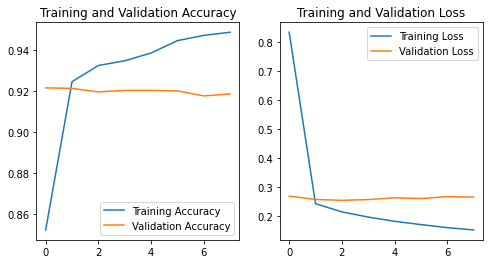

CPU times: user 6.7 s, sys: 392 ms, total: 7.09 s
Wall time: 18.7 s


In [15]:
%%time
transfert_InceptionResNetV2_02, score_transfert_InceptionResNetV2_02 = fit_model(model_InceptionResNetV2_02, 'transfert_InceptionResNetV2_02',train_dataset , validation_dataset,)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Réglage fin

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 sequential_4 (Sequential)   (None, 1536)              0         
                                                           

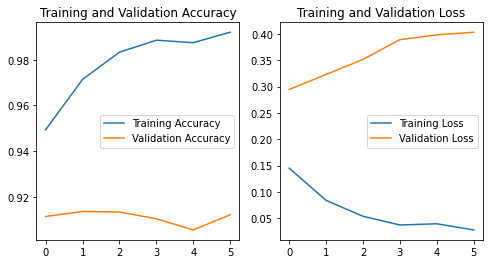

CPU times: user 9.06 s, sys: 966 ms, total: 10 s
Wall time: 24.2 s


In [16]:
%%time
model_base_InceptionResNetV2_02.trainable = True
transfert_InceptionResNetV2_02.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                                    loss='categorical_crossentropy',metrics=['accuracy'])

transfert_InceptionResNetV2_ajust_02,score_transfert_InceptionResNetV2_ajust_02 = fit_model(transfert_InceptionResNetV2_02, 'transfert_InceptionResNetV2_ajust_02',train_dataset , validation_dataset)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'ajout d'une couche de <span STYLE="color:gray;"><i> Dropout</i></span> avant la couche de neurones de sortie ne permet pas de limiter le sur-apprentissage.

In [17]:
score_transfert_InceptionResNetV2_02.iloc[-1] , score_transfert_InceptionResNetV2_ajust_02.iloc[-1]

(loss            0.150798
 accuracy        0.948583
 val_loss        0.264017
 val_accuracy    0.918482
 Name: 7, dtype: float64, loss            0.027726
 accuracy        0.992062
 val_loss        0.403383
 val_accuracy    0.912117
 Name: 5, dtype: float64)

## <a STYLE="padding-left:1em ; color:blue;text-align: justify;" id="2.2">2.2 Modèle InceptionResNetV2 : Dataset : 'birds'</a> 

In [18]:
batch_size = 64
img_shape = (299,299,3)
new_imput = keras.Input(shape=(299,299,3))

path_dir, train_path, test_path , val_path, pred_path , models_path , results_path = choice_path('birds', aug_data = False)
train_dataset, validation_dataset, steps_per_epoch_train, steps_per_epoch_test,class_names = process_files(train_path, test_path , img_shape)

Found 9422 files belonging to 200 classes.
Found 2175 files belonging to 200 classes.
148 34


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 sequential_6 (Sequential)   (None, 1536)              0         
                                                           

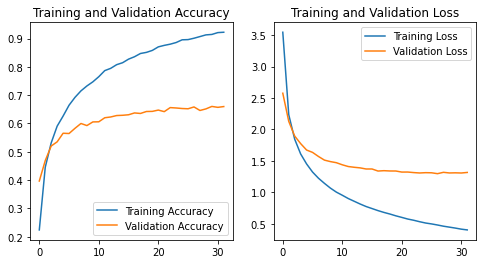

CPU times: user 12.5 s, sys: 623 ms, total: 13.1 s
Wall time: 21.6 s


In [19]:
%%time
model_base_InceptionResNetV2 = InceptionResNetV2(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_InceptionResNetV2.trainable = False
# model_base_InceptionResNetV2.summary()

seq_InceptionResNetV2 = tf.keras.Sequential([GlobalAveragePooling2D()])

model_InceptionResNetV2 = model_build(model_base_InceptionResNetV2 ,seq_InceptionResNetV2,class_names,img_shape, preprocess_input_InceptionResNetV2 ,  aug_data = False  )

transfert_InceptionResNetV2, score_transfert_InceptionResNetV2 = fit_model(model_InceptionResNetV2, 'transfert_InceptionResNetV2',train_dataset , validation_dataset)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Réglage fin

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 sequential_6 (Sequential)   (None, 1536)              0         
                                                           

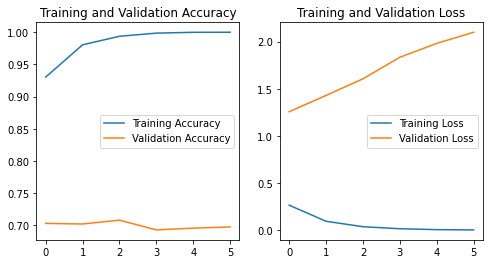

CPU times: user 8.9 s, sys: 1.05 s, total: 9.95 s
Wall time: 23.2 s


In [20]:
%%time
model_base_InceptionResNetV2.trainable = True
transfert_InceptionResNetV2.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                                    loss='categorical_crossentropy',metrics=['accuracy'])

transfert_InceptionResNetV2_ajust, score_transfert_InceptionResNetV2_ajust = fit_model(transfert_InceptionResNetV2,'transfert_InceptionResNetV2_ajust',train_dataset , validation_dataset)  

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Nous observons également un léger sur-apprentissage du modèle. Pour limiter cela, nous allons ajouter une couche de <span STYLE="color:gray;"><i> Dropout</i></span> avant la couche de neurones de sorties.

In [21]:
score_transfert_InceptionResNetV2.iloc[-1] , score_transfert_InceptionResNetV2_ajust.iloc[-1]

(loss            0.401251
 accuracy        0.922203
 val_loss        1.315363
 val_accuracy    0.659770
 Name: 31, dtype: float64, loss            0.002942
 accuracy        0.999894
 val_loss        2.099123
 val_accuracy    0.697471
 Name: 5, dtype: float64)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 sequential_8 (Sequential)   (None, 1536)              0         
                                                           

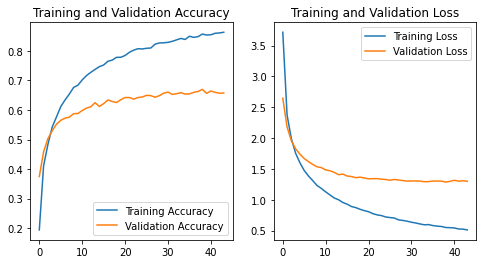

CPU times: user 13 s, sys: 590 ms, total: 13.6 s
Wall time: 24 s


In [22]:
%%time
model_base_InceptionResNetV2_02 = InceptionResNetV2(weights="imagenet", include_top=False,input_tensor=new_imput,input_shape=img_shape )
model_base_InceptionResNetV2_02.trainable = False
# model_base_InceptionResNetV2_02.summary()

seq_InceptionResNetV2_02 = tf.keras.Sequential([GlobalAveragePooling2D(),
                                                layers.Dropout(0.3),
                                                ])

model_InceptionResNetV2_02 = model_build(model_base_InceptionResNetV2_02 ,seq_InceptionResNetV2_02,class_names , img_shape, preprocess_input_InceptionResNetV2, aug_data = False    )

transfert_InceptionResNetV2_02, score_transfert_InceptionResNetV2_02 = fit_model(model_InceptionResNetV2_02, 'transfert_InceptionResNetV2_02',train_dataset , validation_dataset,)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> Réglage fin

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 sequential_8 (Sequential)   (None, 1536)              0     

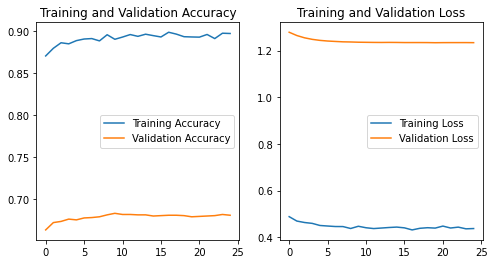

In [23]:
%time
model_base_InceptionResNetV2_02.trainable = True
transfert_InceptionResNetV2_02.compile(optimizer=keras.optimizers.Adam(1e-5),# Low learning rate
                                    loss='categorical_crossentropy',metrics=['accuracy'])

transfert_InceptionResNetV2_ajust_02,score_transfert_InceptionResNetV2_ajust_02 = fit_model(transfert_InceptionResNetV2_02, 'transfert_InceptionResNetV2_ajust_02_birds',train_dataset , validation_dataset)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b> L'ajout d'une couche de <span STYLE="color:gray;"><i> Dropout</i></span> avant la couche de neurones de sortie ne permet pas de limiter le sur-apprentissage.

In [24]:
score_transfert_InceptionResNetV2_02.iloc[-1] , score_transfert_InceptionResNetV2_ajust_02.iloc[-1]

(loss            0.511843
 accuracy        0.863405
 val_loss        1.299957
 val_accuracy    0.657471
 Name: 43, dtype: float64, loss            0.436823
 accuracy        0.897368
 val_loss        1.234256
 val_accuracy    0.680920
 Name: 24, dtype: float64)

# <a STYLE="color:black" id="3">Etape 3 : Vision Transformers</a> 

In [25]:
# Fetch vision_transformer repository.
!pip install -q git+https://github.com/google-research/vision_transformer
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/momentum_clip.py')
files.view('vision_transformer/vit_jax/train.py')

from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint,input_pipeline,utils, models, momentum_clip, train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config
from vit_jax.configs import common as common_config

     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 184 kB 23.6 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 4.9 MB 84.6 MB/s 
     |████████████████████████████████| 287 kB 67.0 MB/s 
     |████████████████████████████████| 4.2 MB 82.4 MB/s 
     |████████████████████████████████| 140 kB 3.1 MB/s 
     |████████████████████████████████| 462 kB 98.2 MB/s 
     |████████████████████████████████| 72 kB 709 kB/s 
Cloning into 'vision_transformer'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 47 (delta 6), reused 13 (delta 3), pack-reused 0
Unpacking objects: 100% (47/47), done.
Already up to date.
     |████████████████████████████████| 155.4 MB 14 kB/s 
     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 190.5 MB 38 kB/s 
gs://vit_models/imag

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

logging.set_verbosity(logging.INFO)
# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


No TPU detected. Can be changed under "Runtime/Change runtime type".


[GpuDevice(id=0, process_index=0)]

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

# def prepare(ds, resize_and_rescale = False , shuffle=False, augment=False):
    
#     data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
#                                         layers.RandomWidth(0.2),
#                                         layers.RandomHeight(0.2),
#                                         layers.RandomRotation(0.2),
#                                         layers.RandomZoom(0.2),
#                                         layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
#                                         layers.RandomContrast(factor=0.2) ] )

#     resize_and_rescale = tf.keras.Sequential([layers.Resizing(img_shape[0], img_shape[1]),
#                                            layers.Rescaling(1./255) ])
#   # Resize and rescale all datasets.
#     if resize_and_rescale:
#         # ds = ds.map(lambda x,y: (resize_and_rescale(x, training=True),y), 
#         #         num_parallel_calls=AUTOTUNE)
#         ds = ds.map(lambda x: resize_and_rescale(x , training=True),num_parallel_calls=AUTOTUNE)
#     if shuffle:
#         ds = ds.shuffle(1000)

# # Batch all datasets.
#     ds = ds.batch(batch_size)

# # Use data augmentation only on the training set.
#     if augment:
#         ds = ds.map(lambda x: data_augmentation(x, training=True), 
#                 num_parallel_calls=AUTOTUNE)

# Use buffered prefetching on all datasets.
    # return ds.prefetch(buffer_size=AUTOTUNE)

def config_vit(path_dir, train_path, test_path, aug_data = False):
    dataset = 'imagenet2012'
    config = common_config.with_dataset(common_config.get_config(), dataset)
    print(config)
    config.batch = batch_size
    config.batch_eval = batch_size
    config.pp.test = 'test'
    config.pp.train = 'train'
    config.dataset = path_dir
    print(config)

    ds_train = input_pipeline.get_data_from_directory(config=config, directory =train_path , mode='train')
    ds_test = input_pipeline.get_data_from_directory(config=config, directory =test_path , mode='test')

    # if aug_data == True : 
    #     ds_train = prepare(ds_train ,  resize_and_rescale = True , shuffle=True, augment=True)
    #     ds_test = prepare(ds_test ,  resize_and_rescale = False , shuffle=False, augment=False)


    # Fetch a batch of test images for illustration purposes.
    batch = next(iter(ds_test.as_numpy_iterator()))
    # Note the shape : [num_local_devices, local_batch_size, h, w, c]
    batch['image'].shape

    return ds_train, ds_test , batch , config

def config_modif(config, var = '' , new=''):
    del config[var]  
    config[var] = new
    return config

def config_model(model_name,batch ):

    if model_name.startswith('ViT'):
        ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
    if model_name.startswith('Mixer'):
        ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

    assert os.path.exists(f'{model_name}.npz')

    model_config = models_config.MODEL_CONFIGS[model_name]
    print(model_config)

    # Load model definition & initialize random parameters.
    # This also compiles the model to XLA (takes some minutes the first time).
    if model_name.startswith('Mixer'):
        model = models.MlpMixer(num_classes=num_classes, **model_config)
    else:
        model = models.VisionTransformer(num_classes=num_classes, **model_config)

    variables = jax.jit(lambda: model.init(jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],train=False,), backend='cpu')()

    # Load and convert pretrained checkpoint.
    # This involves loading the actual pre-trained model results, but then also also
    # modifying the parameters a bit, e.g. changing the final layers, and resizing
    # the positional embeddings.
    # For details, refer to the code and to the methods of the paper.
    params = checkpoint.load_pretrained(pretrained_path=f'{model_name}.npz',
                                    init_params=variables['params'],
                                    model_config=model_config,)
    
    # So far, all our data is in the host memory. Let's now replicate the arrays
    # into the devices.
    # This will make every array in the pytree params become a ShardedDeviceArray
    # that has the same data replicated across all local devices.
    # For TPU it replicates the params in every core.
    # For a single GPU this simply moves the data onto the device.
    # For CPU it simply creates a copy.
    params_repl = flax.jax_utils.replicate(params)
    print('params.cls:', type(params['head']['bias']).__name__,
        params['head']['bias'].shape)
    print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
        params_repl['head']['bias'].shape)
    
    # Then map the call to our model's forward pass onto all available devices.
    vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
                dict(params=params), inputs, train=False))
    
    return model, model_config, variables, params, params_repl, vit_apply_repl

def get_accuracy(params_repl):
    """Returns accuracy evaluated on the test set."""
    good = total = 0
    steps = input_pipeline.get_dataset_info(path_dir, 'test')['num_examples'] // batch_size
    # steps = steps_per_epoch_test
    for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
        predicted = vit_apply_repl(params_repl, batch['image'])
        is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
        good += is_same.sum()
        total += len(is_same.flatten())
    return good / total

def metrics_plot(**args):
    l = 1 
    c = 2 if len(args)%2==0 else 1
    plt.figure(figsize=(4*c, 4))
    i = 1
    for data in args :
        df = args[data]
        if data in 'accuracy' :
            plt.subplot(l, c, 1)
            label = 'Training Accuracy' if 'train' in data else  'Validation Accuracy'
            plt.plot(df, c = 'orange', label = label)
            plt.legend(loc='best')
            plt.title('Validation Accuray')
            
        else: 
            plt.subplot(l, c, i)
            plt.plot(df, label=str(data))
            plt.legend(loc='best')
            plt.title('Training ' + str(data))
        i+=1
    plt.tight_layout()
    plt.show()

In [28]:
img_shape = (229,229,3)
batch_size = 256
path_dir, train_path, test_path , val_path, pred_path , models_path , results_path = choice_path('dogs',  aug_data = False)

train_dataset, validation_dataset, steps_per_epoch_train, steps_per_epoch_test,class_names = process_files(train_path, test_path , img_shape)
num_classes=len(class_names)

ds_train, ds_test , batch , config = config_vit(path_dir, train_path, test_path , aug_data = False)
# model_name : ["ViT-B_32", "Mixer-B_16"]
print('choix entre le modèle : ViT-B_32 ; Mixer-B_16')

model_name = "ViT-B_32"
print(f'modèle choisi {model_name}\n') 
model, model_config, variables, params, params_repl, vit_apply_repl = config_model(model_name,batch )

Found 16376 files belonging to 120 classes.
Found 4085 files belonging to 120 classes.
64 16
accum_steps: 8
base_lr: 0.03
batch: 512
batch_eval: 512
checkpoint_every: 1000
dataset: imagenet2012
decay_type: cosine
eval_every: 100
grad_norm_clip: 1.0
model: null
model_or_filename: null
optim_dtype: bfloat16
pp: {crop: 384, test: validation, train: 'train[:99%]'}
prefetch: 2
pretrained_dir: .
progress_every: 10
shuffle_buffer: 50000
tfds_data_dir: null
tfds_manual_dir: null
total_steps: 20000
trainer: train
warmup_steps: 500

accum_steps: 8
base_lr: 0.03
batch: 256
batch_eval: 256
checkpoint_every: 1000
dataset: /content/drive/MyDrive/Colab Notebooks/P07//Dataset/Dataset_dogs/
decay_type: cosine
eval_every: 100
grad_norm_clip: 1.0
model: null
model_or_filename: null
optim_dtype: bfloat16
pp: {crop: 384, test: test, train: train}
prefetch: 2
pretrained_dir: .
progress_every: 10
shuffle_buffer: 50000
tfds_data_dir: null
tfds_manual_dir: null
total_steps: 20000
trainer: train
warmup_steps: 5

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant
INFO:absl:load_pretrained: resized variant: (1, 50, 768) to (1, 145, 768)
INFO:absl:load_pretrained: grid-size from 7 to 12


params.cls: DeviceArray (120,)
params_repl.cls: ShardedDeviceArray (1, 120)


In [29]:
def param_vit(**kwargs) :

    param = {'total_steps' : 100, 'warmup_steps' : 5,'decay_type' : 'cosine',
            'grad_norm_clip' : 1,'accum_steps' : 8,'base_lr' : 0.03}
    if len(kwargs)>0 : 
        for name , value in kwargs.items() : 
            if name in param : 
                param[name] = value 

    # Check out train.make_update_fn in the editor on the right side for details.
    lr_fn = utils.create_learning_rate_schedule(param['total_steps'], param['base_lr'], param['decay_type'], param['warmup_steps'])
    update_fn_repl = train.make_update_fn(apply_fn=model.apply, accum_steps=param['accum_steps'], lr_fn=lr_fn)

    infer_fn_repl = jax.pmap(functools.partial(model.apply, train=False))

    # We use a momentum optimizer that uses half precision for state to save
    # memory. It als implements the gradient clipping.
    opt = momentum_clip.Optimizer(grad_norm_clip=param['grad_norm_clip']).create(params)
    opt_repl = flax.jax_utils.replicate(opt)

    # Initialize PRNGs for dropout.
    update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

    return lr_fn , update_fn_repl , infer_fn_repl , opt , opt_repl , update_rng_repl , param['total_steps']

In [30]:
lr_fn , update_fn_repl , infer_fn_repl , opt , opt_repl , update_rng_repl , total_steps = param_vit()

/usr/local/lib/python3.7/dist-packages/flax/optim/base.py:52: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  'for detailed instructions.', DeprecationWarning)


In [31]:
%%time
def fit_vit(name ='ViT_Finetune' , opt_repl = opt_repl , update_rng_repl = update_rng_repl , total_steps= total_steps ):
    if os.path.isfile(results_path+'losses_'+str(name)+'_384.joblib'):
        losses = load(results_path+'losses_'+str(name)+'_384.joblib')
        lrs =  load(results_path+'lrs_'+str(name)+'_384.joblib')
        accuracy_test =  load(results_path+'accuracy_test_'+str(name)+'_384.joblib')
        metrics_plot( losses = losses, lrs = lrs  ) 
        metrics_plot( accuracy = accuracy_test ) 
    else : 
        losses = []
        lrs = []
        accuracy_test = []
        # accuracy_train = []

        for step, batch in zip(tqdm.trange(1, total_steps + 1),ds_train.as_numpy_iterator(),):
            opt_repl, loss_repl, update_rng_repl = update_fn_repl(opt_repl, flax.jax_utils.replicate(step),batch, update_rng_repl)
            losses.append(loss_repl[0])
            lrs.append(lr_fn(step))
            accuracies_test = []
            # accuracies_train = []

            # if ((config.eval_every and step % config.eval_every == 0) or (step == total_steps)):

            for test_batch in input_pipeline.prefetch(ds_test, config.prefetch):
                logits_test = infer_fn_repl(dict(params=opt_repl.target), test_batch['image'])
                accuracies_test.append((np.argmax(logits_test,axis=-1) ==np.argmax(test_batch['label'],axis=-1)).mean())
                    
            accuracy_test.append(np.mean(accuracies_test))  
        
            # for train_batch in input_pipeline.prefetch(ds_train, config.prefetch):
            #     logits_train = infer_fn_repl(dict(params=opt_repl.target), train_batch['image'])
            #     accuracies_train.append((np.argmax(logits_train,axis=-1) ==np.argmax(train_batch['label'],axis=-1)).mean())
                    
            # accuracy_train.append(np.mean(accuracies_train))  
        
        dump(losses,results_path+'losses_'+str(name)+'_384.joblib')
        dump(lrs,results_path+'lrs_'+str(name)+'_384.joblib')
        dump(accuracy_test,results_path+'accuracy_test_'+str(name)+'_384.joblib')
        # dump(accuracy_train,results_path+'accuracy_train'+str(name)+'.joblib')

        metrics_plot( losses = losses, lrs = lrs ) 
        metrics_plot( accuracy_test = accuracy_test ) 

    return losses , lrs ,  accuracy_test 

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.58 µs


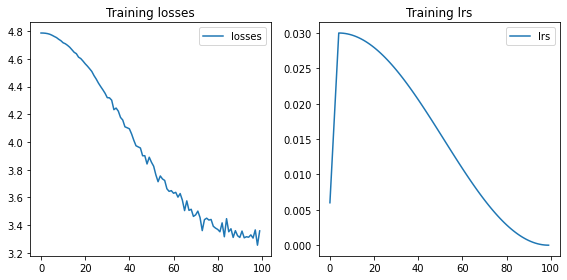

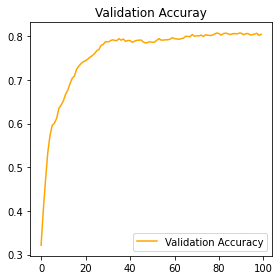

In [32]:
losses , lrs , accuracy_test  = fit_vit(name ='ViT_Finetune', opt_repl = opt_repl , update_rng_repl = update_rng_repl ,total_steps = total_steps)

In [33]:
img_shape = (229,229,3)
batch_size = 256
path_dir, train_path, test_path , val_path, pred_path , models_path , results_path = choice_path('birds',  aug_data = False)

train_dataset, validation_dataset, steps_per_epoch_train, steps_per_epoch_test,class_names = process_files(train_path, test_path , img_shape)
num_classes=len(class_names)

ds_train, ds_test , batch , config = config_vit(path_dir, train_path, test_path , aug_data = False)
# model_name : ["ViT-B_32", "Mixer-B_16"]
print('choix entre le modèle : ViT-B_32 ; Mixer-B_16')

model_name = "ViT-B_32"
print(f'modèle choisi {model_name}\n') 
model, model_config, variables, params, params_repl, vit_apply_repl = config_model(model_name,batch )

lr_fn , update_fn_repl , infer_fn_repl , opt , opt_repl , update_rng_repl , total_steps = param_vit()

Found 9422 files belonging to 200 classes.
Found 2175 files belonging to 200 classes.
37 9
accum_steps: 8
base_lr: 0.03
batch: 512
batch_eval: 512
checkpoint_every: 1000
dataset: imagenet2012
decay_type: cosine
eval_every: 100
grad_norm_clip: 1.0
model: null
model_or_filename: null
optim_dtype: bfloat16
pp: {crop: 384, test: test, train: train}
prefetch: 2
pretrained_dir: .
progress_every: 10
shuffle_buffer: 50000
tfds_data_dir: null
tfds_manual_dir: null
total_steps: 20000
trainer: train
warmup_steps: 500

accum_steps: 8
base_lr: 0.03
batch: 256
batch_eval: 256
checkpoint_every: 1000
dataset: /content/drive/MyDrive/Colab Notebooks/P07//Dataset/Dataset_birds/
decay_type: cosine
eval_every: 100
grad_norm_clip: 1.0
model: null
model_or_filename: null
optim_dtype: bfloat16
pp: {crop: 384, test: test, train: train}
prefetch: 2
pretrained_dir: .
progress_every: 10
shuffle_buffer: 50000
tfds_data_dir: null
tfds_manual_dir: null
total_steps: 20000
trainer: train
warmup_steps: 500

choix entre

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant
INFO:absl:load_pretrained: resized variant: (1, 50, 768) to (1, 145, 768)
INFO:absl:load_pretrained: grid-size from 7 to 12
/usr/local/lib/python3.7/dist-packages/flax/optim/base.py:52: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  'for detailed instructions.', DeprecationWarning)


params.cls: DeviceArray (200,)
params_repl.cls: ShardedDeviceArray (1, 200)


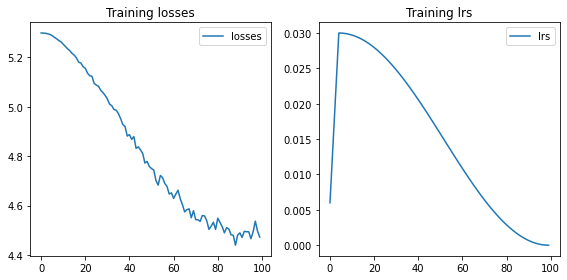

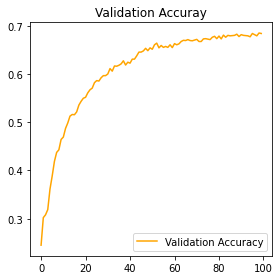

In [34]:
losses_birds , lrs_birds , accuracy_test_birds = fit_vit(name ='ViT_Finetune', opt_repl = opt_repl , update_rng_repl = update_rng_repl, total_steps= total_steps )

In [35]:
accuracy_test[-1], accuracy_test_birds[-1]

(0.8044271, 0.68408203)